In [1]:
import numpy as np
from IPython.display import Image

NN_ARCHITECTURE 是神经网络架构

input_dim 是网络层输入的信号向量的大小
output_dim 是网络层输出的激活向量的大小
activation 是网络层所用的激活参数

In [2]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

<img src="https://pic1.zhimg.com/v2-26bef6b74aced068fcf28245783a5890_r.jpg" style="width: 50%; height: 50%"/>

网络层参数初始化
用随机数字填充矩阵 W 和向量 b

In [3]:
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1
        
    return params_values

<img src="https://pic3.zhimg.com/v2-a2765390aca43bd26e0b2f31883d768d_r.jpg" />

激活函数 sigmoid 和 ReLU
为支持 前向传播 和 反向传播 给出  sigmoid导数 和 ReLU导数

In [4]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

<img src="https://pic4.zhimg.com/v2-a658865c292b86272dd141074d902936_b.gif" />

### 前向传播

单层前向传播

In [5]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')

    return activation_func(Z_curr), Z_curr

<img src="https://pic4.zhimg.com/v2-b999ab8463b39b4d83a3c8b34ba24d61_r.jpg" />

整个神经网络前向传播

In [6]:
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr

        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)

        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr

    return A_curr, memory

### 损失函数(因为用于 二元分类， 所以使用 交叉熵) 
### 精确度函数

<img src="https://pic4.zhimg.com/80/v2-d6c5099a64d527fae9d71185ac140ff8_hd.jpg" />

In [7]:
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [8]:
def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1/m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

### 反向传播

<img src="https://pic1.zhimg.com/80/v2-5fc57e2810db599083074aa6c96bbe6a_hd.jpg" />

单层反向传播

In [9]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]

    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

整个神经网络反向传播

In [10]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
    
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

<img src="https://pic1.zhimg.com/v2-ffb7dc9760f74bc720f2745eda6d777e_r.jpg" style="width: 50%; height: 50%"/>

### 更新参数值

params_values 保存当前参数值
grads_values 保存用于更新参数值所需的梯度信息

<img src="https://pic1.zhimg.com/80/v2-9a012f6018fe0e2728aa57941d0aba53_hd.jpg" />

In [11]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

### 训练 

整合一切

In [12]:
def train(X, Y, nn_architecture, epochs, learning_rate):
    params_values = init_layers(nn_architecture, 2)
    cost_history = []
    accuracy_history = []

    for i in range(epochs):
        Y_hat, cache = full_forward_propagation(X, params_values, nn_architecture)

        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)

        grads_values = full_backward_propagation(Y_hat, Y, cache, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
            
    return params_values

<img src="https://pic2.zhimg.com/v2-f06b5d07704d965a3c65078ffd7d95af_b.gif" />

## 实测 

In [13]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

Using TensorFlow backend.


### 设置

In [14]:
# 数据集 样本数量
N_SAMPLES = 1000
# 数据集与训练集的比例 
TEST_SIZE = 0.1

### 创建数据集

In [15]:
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

### 辅助绘图函数

In [16]:
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

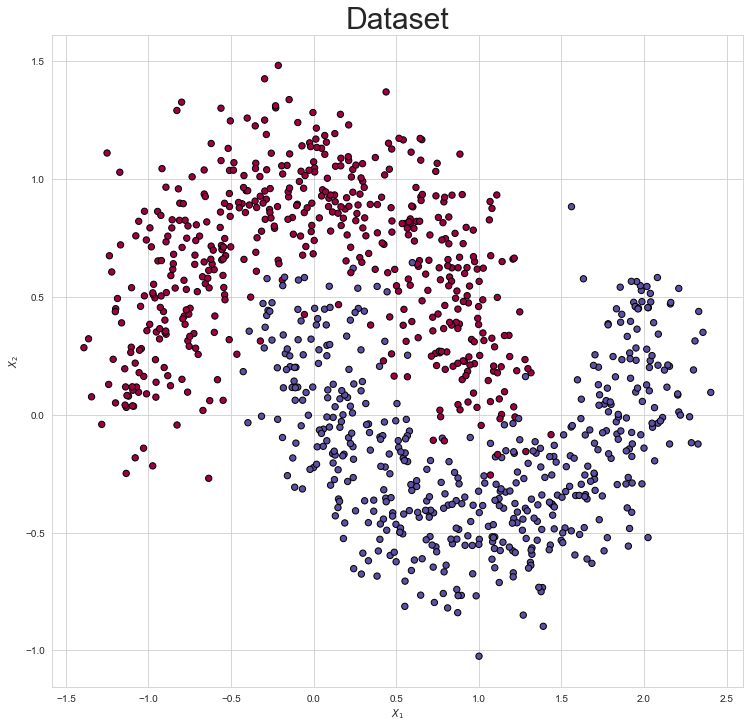

In [17]:
make_plot(X, y, "Dataset")

### 模型测试 

In [18]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01)

In [19]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [20]:
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} - David".format(acc_test))

Test set accuracy: 0.46 - David
